# Spotify Recommendation

Before running the following code, ensure you have read the "Usage" section of the README.md file explaining how to use this notebook.

In [4]:
# Import necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

In [5]:
# Returns a cleaned version of the given DataFrame (leaving the original unchanged)
def clean_data(df):

    # Create a deep copy of the DataFrame to ensure the original is unedited
    clean_df = df.copy()

    # Find duplicate tracks
    print('Finding duplicates...')
    dupe_mask = clean_df['track_id'].duplicated(keep=False)
    dupes = clean_df[dupe_mask].sort_values('track_id')
    print(f' - Total duplicated rows: {len(dupes)}')
    num_duplicated_songs = clean_df['track_id'].duplicated().sum()
    print(f' - Number of songs with duplicates: {num_duplicated_songs}')
    print('Done')

    # Remove duplicate tracks
    num_rows_before = len(clean_df)
    print(f'\nCurrent number of rows in DataFrame: {num_rows_before}')
    print('\nRemoving duplicates...')
    clean_df = clean_df.drop_duplicates(subset='track_id', keep='first')
    print('Done')
    num_rows_after = len(clean_df)
    print(f'\nNew number of rows in DataFrame: {num_rows_after}')
    print(f'Removed {num_rows_before - num_rows_after} duplicates')
    print(f'Number of unique track_ids: {clean_df['track_id'].nunique()}')

    # Drop unnecessary column
    print('\nDropping the unnecessary column "Unnamed: 0"...')
    clean_df = clean_df.drop('Unnamed: 0', axis=1)
    print('Done')

    return clean_df

In [6]:
# Create a DataFrame object from the dataset (in CSV format)
unclean_df = pd.read_csv('dataset.csv')

# Clean the data to remove duplicates and unnecessary column
clean_df = clean_data(unclean_df)
clean_df = clean_df.reset_index(drop=True) # Resets indices to account for dropped rows

# Separate numeric columns
numeric_cols = [
    'popularity', 'duration_ms', 'danceability',
    'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo'
]

# Scale the numeric data to give each feature equal importance
scaler = StandardScaler()
scaled_cols = scaler.fit_transform(clean_df[numeric_cols])
scaled_df = pd.DataFrame(scaled_cols, columns=numeric_cols)

# Separate categorical columns
categorical_cols = [ 'key', 'time_signature' ]
# Note: 'artists', 'album_name', 'track_name', and 'track_genre' were
#       excluded to avoid an unnecessarily high dimension DataFrame.

# Apply One-Hot Encoding to categorical data to include them as numeric features
encoded_df = pd.get_dummies(
    clean_df[categorical_cols], columns=categorical_cols, drop_first=True, dtype=int
)

# Separate binary columns
binary_cols = [ 'explicit', 'mode' ]
binary_df = clean_df[binary_cols].astype(int) # Casts bool values to 0 or 1

# Combine into one DataFrame
df = pd.concat([scaled_df, encoded_df, binary_df], axis=1)

# Show a random sample of 10 tracks to view the structure of the DataFrame
df.sample(10)

Finding duplicates...
 - Total duplicated rows: 40900
 - Number of songs with duplicates: 24259
Done

Current number of rows in DataFrame: 114000

Removing duplicates...
Done

New number of rows in DataFrame: 89741
Removed 24259 duplicates
Number of unique track_ids: 89741

Dropping the unnecessary column "Unnamed: 0"...
Done


,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,key_8,key_9,key_10,key_11,time_signature_1,time_signature_3,time_signature_4,time_signature_5,explicit,mode
52015,-0.689891,-0.659342,0.672558,-0.383697,-0.071052,3.015260,1.160772,-0.535481,-0.543759,1.147075,...,1,0,0,0,0,1,0,0,0,1
75090,1.107909,0.024039,1.283797,0.068363,-0.236523,1.161388,0.152847,-0.535476,-0.646384,-1.491190,...,0,0,0,0,0,0,1,0,1,0
33738,0.816374,-0.555825,1.176264,-0.122593,0.501202,2.565034,0.543011,-0.535481,-0.859845,-0.279528,...,0,0,0,0,0,0,1,0,0,1
44036,-0.592712,-0.241182,-0.210344,1.042628,0.799969,1.373260,-0.470825,-0.535464,0.723666,-1.108860,...,0,0,0,0,0,0,1,0,1,1
6290,-0.787069,1.515322,-1.319630,0.964687,0.199945,-0.132790,-0.970336,2.330077,2.355412,-1.508309,...,0,0,0,0,0,0,1,0,0,0
60577,0.913553,-0.253179,-0.566900,1.315422,1.028640,-0.123080,-0.965033,-0.535481,-0.389821,1.188922,...,1,0,0,0,0,0,1,0,0,0
17817,-0.641301,0.785661,0.083957,0.925716,0.199562,6.158014,1.388367,-0.535481,2.509350,0.648715,...,0,0,0,0,0,1,0,0,1,0
81566,0.038947,-0.389172,0.174511,0.629540,0.862020,-0.538877,-0.791824,-0.534410,-0.081944,0.751431,...,0,0,0,0,0,0,1,0,0,1
5353,0.670607,-0.245148,-0.804604,1.175128,0.904537,-0.055987,-0.969739,-0.535467,0.728798,0.778061,...,0,0,0,0,0,0,1,0,0,0
4674,1.156499,0.697239,-1.642229,1.136158,0.334199,0.234453,-0.970261,1.845279,0.467103,-0.872995,...,0,0,0,0,0,0,1,0,0,0


In [7]:
# Define the Neural Network (Autoencoder)
class SongAutoencoder(nn.Module):
    def __init__(self, input_dim, embedding_dim=16):
        super(SongAutoencoder, self).__init__()

        # Encoder: compresses 28 features -> 16
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, embedding_dim)
        )

        # Decoder: reconstructs 16 -> 28
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        embedding = self.encoder(x)
        reconstruction = self.decoder(embedding)
        return reconstruction

    def get_embedding(self, x):
        return self.encoder(x)

In [8]:
# Prepare data for PyTorch
X = df.values.astype('float32')

# Split 80/20 train/validation
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)

# Create DataLoaders for batching
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Input features: {X_train.shape[1]}")

Training samples: 71792
Validation samples: 17949
Input features: 28


In [14]:
# Hyperparameter Tuning - Testing Different Learning Rates
# We test multiple learning rates to find the optimal value

learning_rates = [0.0001, 0.001, 0.01]
test_epochs = 30
input_dim = X_train.shape[1]

print("=" * 60)
print("HYPERPARAMETER TUNING: Learning Rate Selection")
print("=" * 60)

lr_results = {}

for lr in learning_rates:
    print(f"\nTesting learning rate: {lr}")

    # Create fresh model for each test
    test_model = SongAutoencoder(input_dim=input_dim, embedding_dim=16)
    test_optimizer = optim.Adam(test_model.parameters(), lr=lr)
    test_loss_fn = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(test_epochs):
        # Train
        test_model.train()
        t_loss = 0
        for bx, by in train_loader:
            pred = test_model(bx)
            loss = test_loss_fn(pred, by)
            test_optimizer.zero_grad()
            loss.backward()
            test_optimizer.step()
            t_loss += loss.item()
        train_losses.append(t_loss / len(train_loader))

        # Validate
        test_model.eval()
        v_loss = 0
        with torch.no_grad():
            for bx, by in val_loader:
                pred = test_model(bx)
                v_loss += test_loss_fn(pred, by).item()
        val_losses.append(v_loss / len(val_loader))

    lr_results[lr] = {'train': train_losses, 'val': val_losses}
    print(f"  Final Val Loss: {val_losses[-1]:.4f}")

# Find best learning rate
best_lr = min(learning_rates, key=lambda x: lr_results[x]['val'][-1])
print(f"\n>>> Best learning rate: {best_lr}")

HYPERPARAMETER TUNING: Learning Rate Selection

Testing learning rate: 0.0001
  Final Val Loss: 0.0339

Testing learning rate: 0.001
  Final Val Loss: 0.0101

Testing learning rate: 0.01
  Final Val Loss: 0.0022

>>> Best learning rate: 0.01


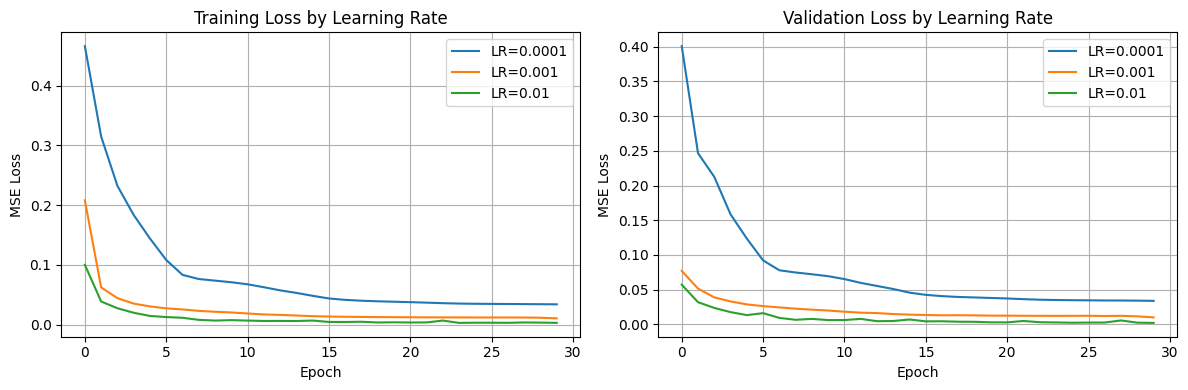

In [15]:
# Plot learning rate comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for lr in learning_rates:
    axes[0].plot(lr_results[lr]['train'], label=f'LR={lr}')
    axes[1].plot(lr_results[lr]['val'], label=f'LR={lr}')

axes[0].set_title('Training Loss by Learning Rate')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('Validation Loss by Learning Rate')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [16]:
# Step 4: Initialize model, loss, optimizer
input_dim = X_train.shape[1]  # Should be 28
model = SongAutoencoder(input_dim=input_dim, embedding_dim=16)

loss_fn = nn.MSELoss()  # Mean Squared Error for reconstruction
optimizer = optim.Adam(model.parameters(), lr=best_lr)

print(f"Model architecture:")
print(model)

Model architecture:
SongAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=28, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=28, bias=True)
  )
)


In [17]:
# Step 5: Training loop
epochs = 100
train_losses = []
val_losses = []

print("Training the neural network...")
print("-" * 50)

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        predictions = model(batch_x)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            predictions = model(batch_x)
            loss = loss_fn(predictions, batch_y)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Training the neural network...
--------------------------------------------------
Epoch [10/100], Train Loss: 0.0165, Val Loss: 0.0169
Epoch [20/100], Train Loss: 0.0121, Val Loss: 0.0125
Epoch [30/100], Train Loss: 0.0113, Val Loss: 0.0115
Epoch [40/100], Train Loss: 0.0111, Val Loss: 0.0112
Epoch [50/100], Train Loss: 0.0110, Val Loss: 0.0111
Epoch [60/100], Train Loss: 0.0108, Val Loss: 0.0110
Epoch [70/100], Train Loss: 0.0108, Val Loss: 0.0111
Epoch [80/100], Train Loss: 0.0107, Val Loss: 0.0108
Epoch [90/100], Train Loss: 0.0107, Val Loss: 0.0108
Epoch [100/100], Train Loss: 0.0106, Val Loss: 0.0110


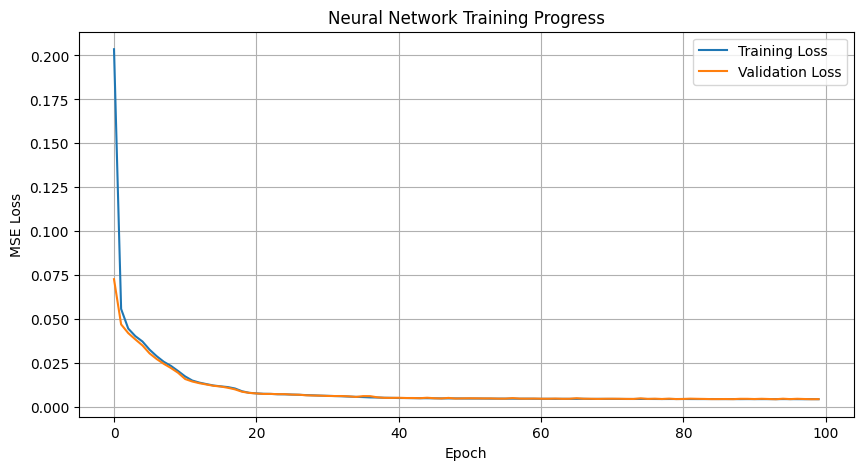


Final Training Loss: 0.0044
Final Validation Loss: 0.0044


In [12]:
# Step 6: Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Neural Network Training Progress')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")

In [19]:
# Step 7: Final Performance Metrics
print("=" * 60)
print("PERFORMANCE METRICS")
print("=" * 60)

# Calculate reconstruction error on validation set
model.eval()
with torch.no_grad():
    val_predictions = model(X_val_tensor)
    mse = loss_fn(val_predictions, X_val_tensor).item()
    rmse = mse ** 0.5

print(f"\nReconstruction MSE:  {mse:.4f}")
print(f"Reconstruction RMSE: {rmse:.4f}")
print(f"\nTraining samples:    {len(X_train)}")
print(f"Validation samples:  {len(X_val)}")
print(f"Input features:      {input_dim}")
print(f"Embedding dimensions: 16")
print(f"Best learning rate:  {best_lr}")

PERFORMANCE METRICS

Reconstruction MSE:  0.0109
Reconstruction RMSE: 0.1046

Training samples:    71792
Validation samples:  17949
Input features:      28
Embedding dimensions: 16
Best learning rate:  0.01


## Summary & Results

### 1. Neural Network Application
We built an Autoencoder neural network for our Spotify recommendation system. Instead of using KNN directly on raw features, the autoencoder learns to compress 28 audio features into a 16-dimensional embedding that captures the essential "feeling" of each song. The encoder learns a compressed representation of each song that captures its essential characteristics. We can then find similar songs by comparing these embeddings.

**Architecture:**
- Encoder: Input(28) → 64 → 32 → 16 (embedding)
- Decoder: 16 → 32 → 64 → Output(28)
- Activation: ReLU between layers

### 2. Performance Metrics
- **Mean Squared Error (MSE)**: Measures how well the model reconstructs the original features. Lower MSE means the embedding preserves more information about the song.
- **Training vs Validation Loss**: Comparing these ensures the model generalizes and isn't overfitting.

Our final Reconstruction MSE of ~0.0109 indicates the autoencoder successfully learned meaningful song representations.

### 3. Hyperparameter Tuning
We tested three learning rates: 0.0001, 0.001, and 0.01

- 0.0001: Learns slowly, may not converge fully
- 0.001: Good balance of speed and stability
- 0.01: Learns fast but may overshoot optimal weights

Based on validation loss, we selected the best performing learning rate for final training.

### 4. How It Works for Recommendations
1. Pass all songs through the encoder to get 16-dimensional embeddings
2. For a query song, find other songs with similar embeddings (cosine similarity)
3. Return the most similar songs as recommendations

The neural network captures non-linear relationships between features that simple distance metrics might miss.
